# Nonlinearities on gain vector

This uses f(g) = g^{alpha + 1} or f(g)=exp(g) as the nonlinearity on g, as a means to prevent negative values.

Seems to increase in convergence speed for with increasing alpha

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import frame_whitening as fw
from frame_whitening.types import *
import frame_whitening.simulation as fwsim

os.chdir(os.path.expanduser("~/frame_whitening"))
print(os.getcwd())

/mnt/home/lduong/frame_whitening


## Set-up data

In [2]:
seed = 42069
np.random.seed(seed)
batch_size = 256
n_batch = 10000
lr_g = 5e-4

Q = fw.rot2(np.deg2rad(30))
kappa = 8
Cxx0 = Q @ np.diag([kappa, 1]) @ Q.T * 1 / (np.sqrt(kappa))

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0]]
W = fw.get_mercedes_frame()
N, K = W.shape

## Run simulations for different nonlinearities

- f(g) = exp(g)
- f(g) = g*exp(g)
- f(g) = g^{alpha + 1}

In [3]:
data = {}

# simulate f(g) = exp(g) and f(g) = g*exp(g)
for func_type in [FuncType.EXPONENTIAL, FuncType.G_EXPONENTIAL]:
    g0 = fwsim.init_g_const(0.1, K, func_type)
    get_y, get_dg = fwsim.get_opt_funcs(func_type)
    g_last, g_all, errors = fwsim.simulate(
        cholesky_list,
        W,
        get_y,
        get_dg,
        batch_size,
        n_batch,
        lr_g,
        g0=g0,
        seed=seed,
    )
    data[(func_type,)] = (g_last, g_all, errors)


# simulate f(g) = g^(alpha+1)
get_y, get_dg = fwsim.get_opt_funcs(FuncType.POWER)
alphas = [0.0, 1.0, 2.0, 3.0]
for i, alpha in enumerate(alphas):
    g0 = fwsim.init_g_const(0.1, K, FuncType.POWER, alpha=alpha)

    g_last, g_all, errors = fwsim.simulate(
        cholesky_list,
        W,
        partial(get_y, alpha=alpha),
        partial(get_dg, alpha=alpha),
        batch_size,
        n_batch,
        lr_g,
        g0=g0,
        seed=seed,
    )

    data[(FuncType.POWER, alpha)] = (g_last, g_all, errors)

## Plot empirical convergence results

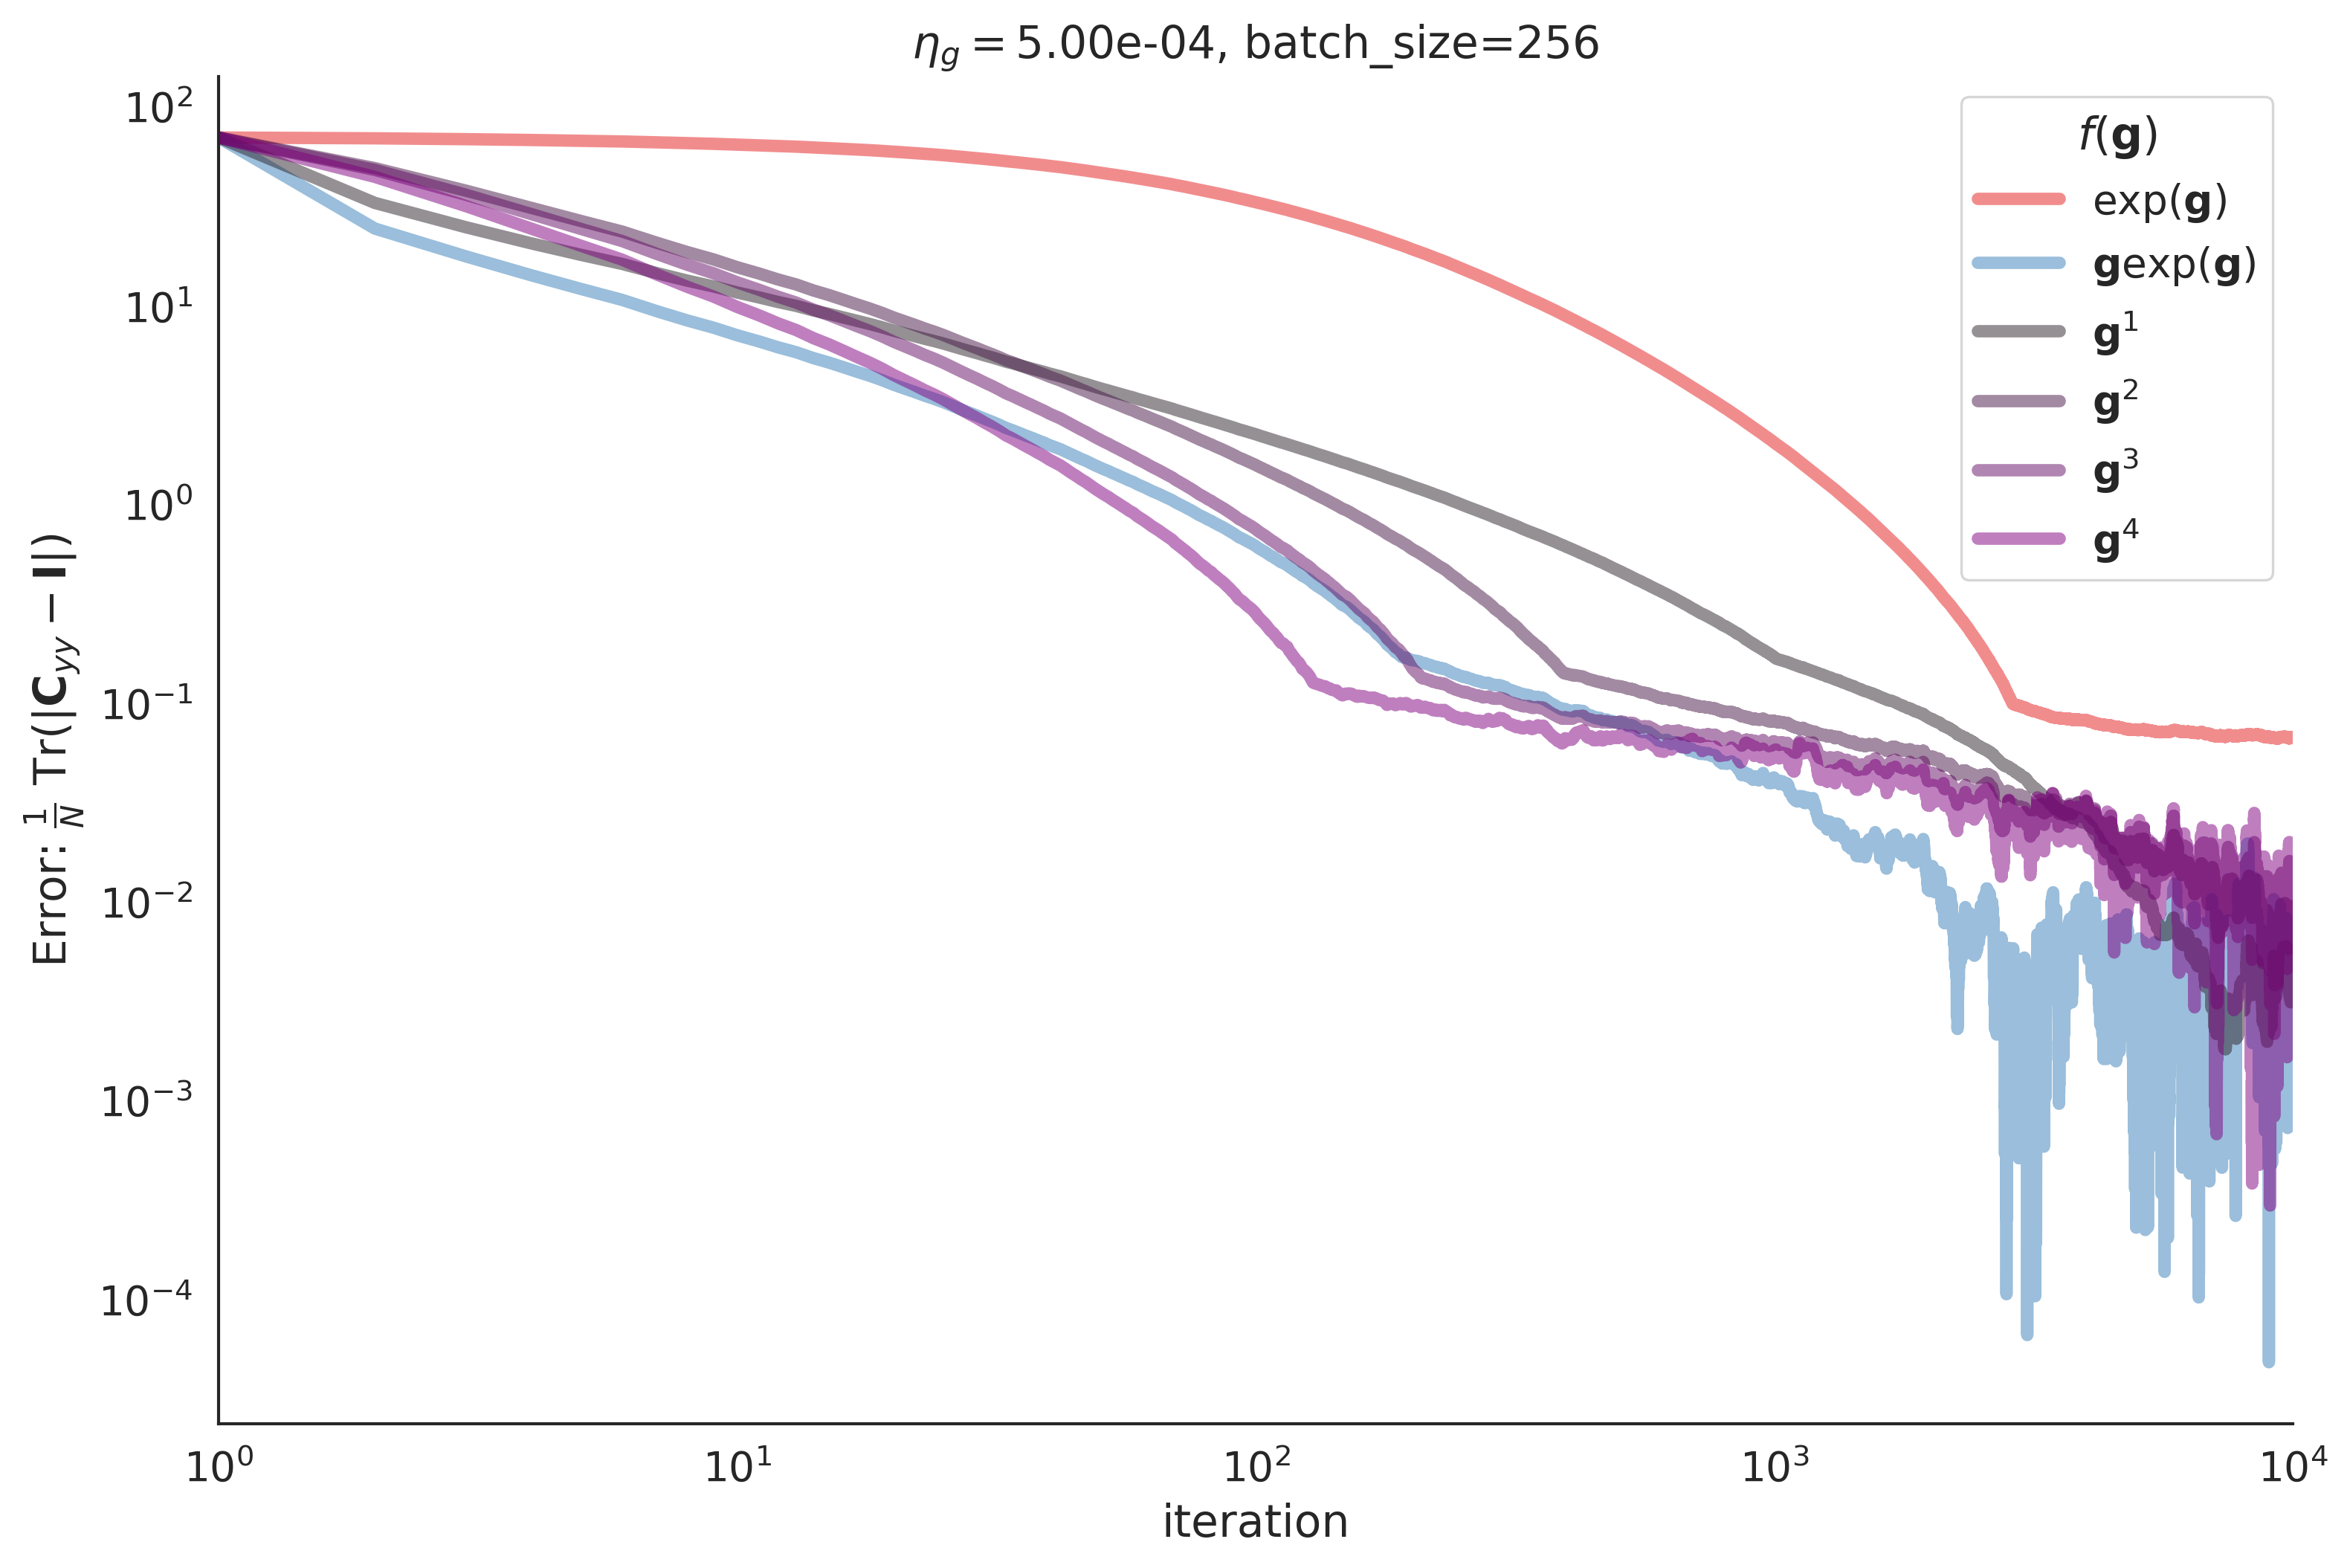

In [4]:
x_iter = range(1, n_batch + 1)
with sns.plotting_context("paper", font_scale=1.5):
    sns.set_style("white")
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
    cols_pow = sns.dark_palette("purple", len(alphas))
    cols = np.concatenate([sns.color_palette("Set1", 2), cols_pow], 0)
    N, K = W.shape

    for i, key in enumerate(data.keys()):
        errors = data[key][-1]
        if key[0] == FuncType.EXPONENTIAL:
            label = r"$\exp({\bf g})$"
        elif key[0] == FuncType.G_EXPONENTIAL:
            label = r"${\bf g}\exp({\bf g})$"
        elif key[0] == FuncType.POWER:
            alpha = key[1]
            label = r"${\bf g}^" + f"{alpha+1:.0f}" + r"$"

        ax.plot(x_iter, errors, color=cols[i], label=label, linewidth=4, alpha=0.5)

    ax.set(
        yscale="log",
        xscale="log",
        # ylim=(1e-4, 1e2),
        xlim=(1, n_batch),
        xlabel="iteration",
        ylabel=r"Error: $\frac{1}{N}$ Tr($\vert {\bf C}_{yy} - {\bf I} \vert$)",
        title=f"$\eta_g=${lr_g:.2e}, batch_size={batch_size}",
    )
    ax.legend(title=r"$f({\bf g})$")
    sns.despine()